In [114]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "G:/Shared drives/Projection-seq/Mouse_V1/Gluta_NR/"

adata = sc.read_h5ad(data_path + "P28_glut.h5ad")
adata

AnnData object with n_obs × n_vars = 15315 × 30869
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Type_colors', 'cluster_colors', "dendrogram_['leiden']", 'hvg', 'layer_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


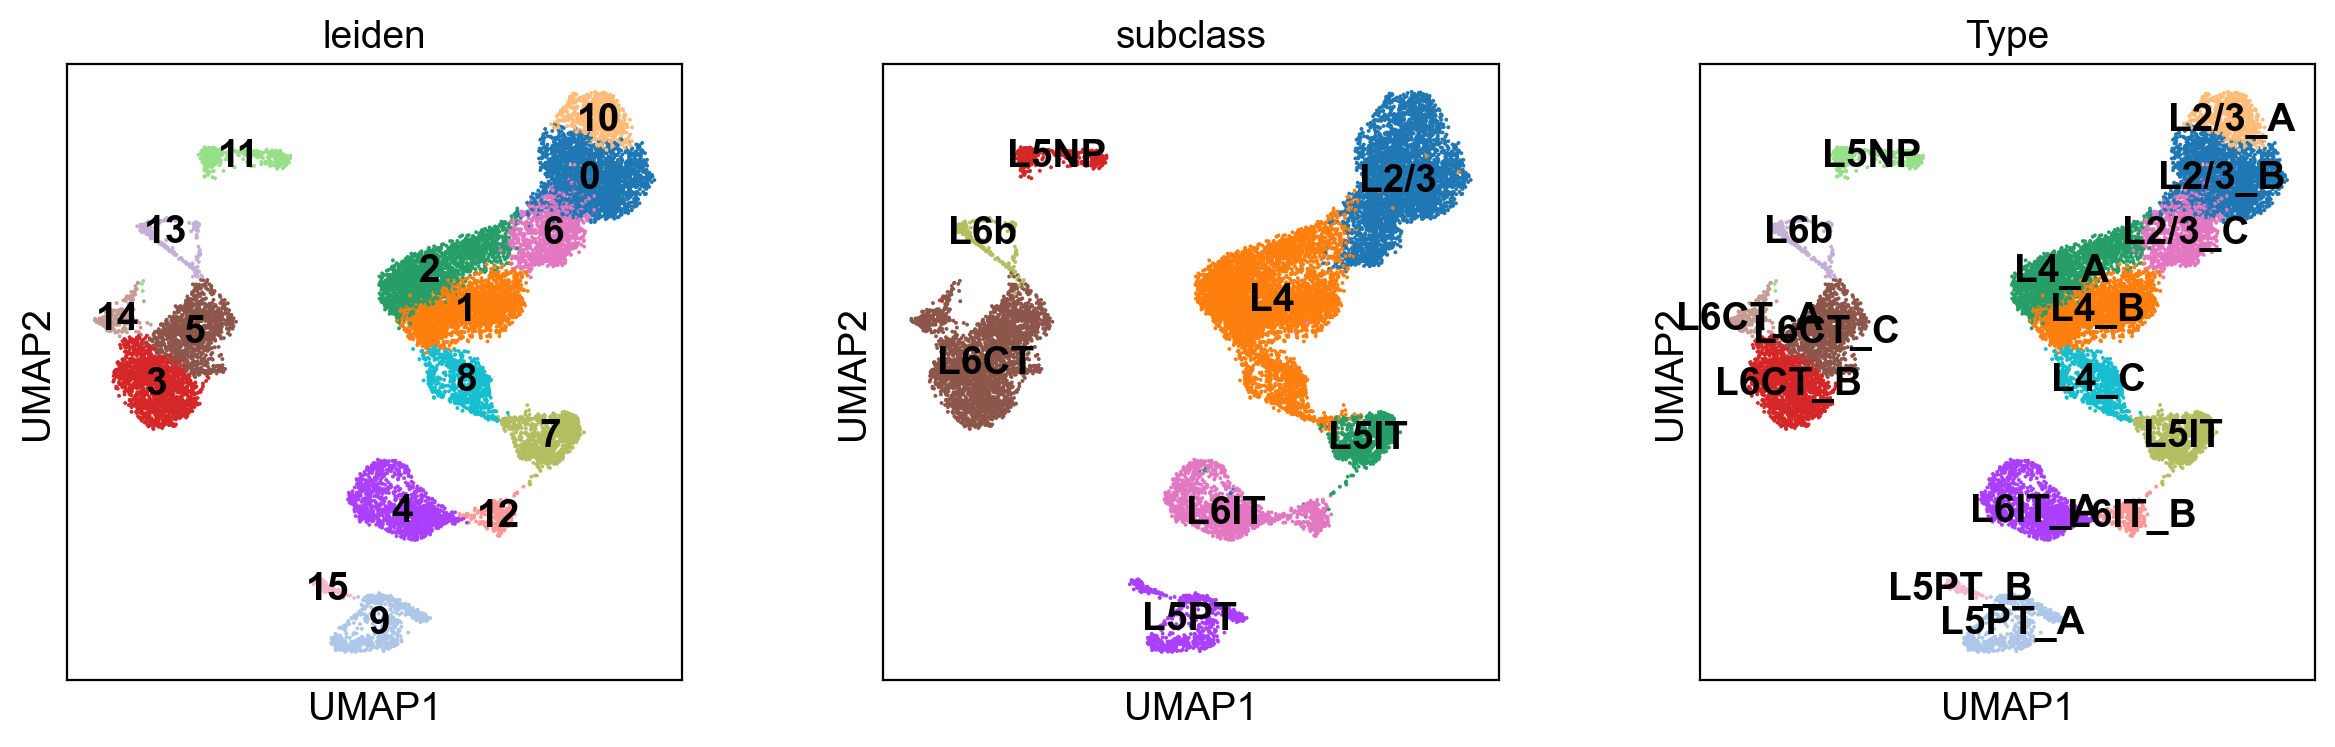

In [23]:
sc.pl.umap(adata, color=["leiden", "subclass", "Type"], legend_loc="on data")

Find Marker Genes for L2/3 Clusters using NS-Forest

In [36]:
l23_idx = ["L2/3_A", "L2/3_B", "L2/3_C"]
l23_mask = np.isin(adata.obs["Type"], l23_idx)
adata_l23 = adata[l23_mask, :]

results = ns.NSForest(
                    adata_l23, 
                    cluster_header="Type", 
                    n_trees=10000, 
                    n_genes_eval=6, 
                    output_folder=data_path + "NSForest/", 
                      )

results.to_csv(data_path + "NSForest/L23_results.csv")

Preparing data...


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\nsforest\nsforest.py:87: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[cluster_header] = adata.obs[cluster_header].astype('category')


--- 0.9454751014709473 seconds ---
Calculating medians...
(4044, 30869)
--- 4.294537782669067 seconds ---
Number of clusters to evaluate: 3
1 out of 3:
	L2/3_B
	Only 6 out of 15 top Random Forest features with median > 0 will be further evaluated.
	['Sorcs3', 'Dlgap2']
	0.7974669356646492
2 out of 3:
	L2/3_C
	Only 9 out of 15 top Random Forest features with median > 0 will be further evaluated.
	['Cdh12', 'Cntnap2']
	0.8415964303420923
3 out of 3:
	L2/3_A
	Only 9 out of 15 top Random Forest features with median > 0 will be further evaluated.
	['Cdh13', '5730522E02Rik']
	0.704449152542373
--- 1511.1472890377045 seconds ---


In [37]:
results = results.reindex([2, 0, 1])
results

,clusterName,clusterSize,f_score,PPV,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes
2,L2/3_A,612,0.704449,0.833856,3379,53,346,266,2,"[Cdh13, 5730522E02Rik]","[Cntn5, Fam155a, Cdh13, 5730522E02Rik, Arhgef2..."
0,L2/3_B,2382,0.797467,0.870336,1450,212,959,1423,2,"[Sorcs3, Dlgap2]","[Bdnf, Igfn1, Nrxn3, Sorcs3, Dlgap2, Egfem1]"
1,L2/3_C,1050,0.841596,0.910188,2927,67,371,679,2,"[Cdh12, Cntnap2]","[Rorb, Cadps2, Chrm2, Fgf14, Cdh12, Cntnap2, K..."


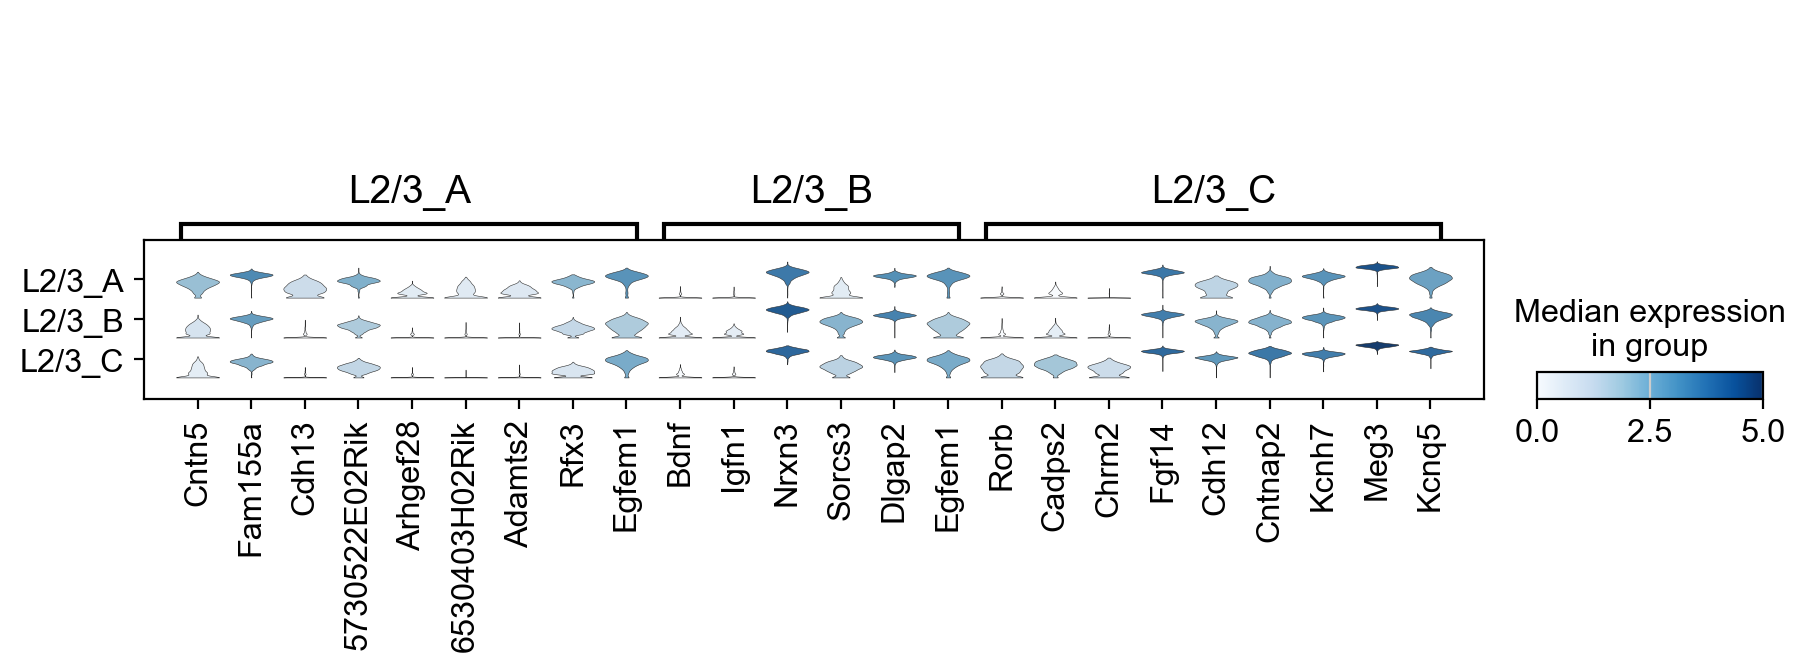

In [41]:
markers = dict(zip(results['clusterName'], results['binary_genes']))

sc.pl.stacked_violin(
        adata_l23, markers, 
        groupby="Type", 
        categories_order=["L2/3_A", "L2/3_B", "L2/3_C"], 
        var_group_rotation=0, 
        swap_axes=False, 
        vmin=0, vmax=5, 
                    )

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


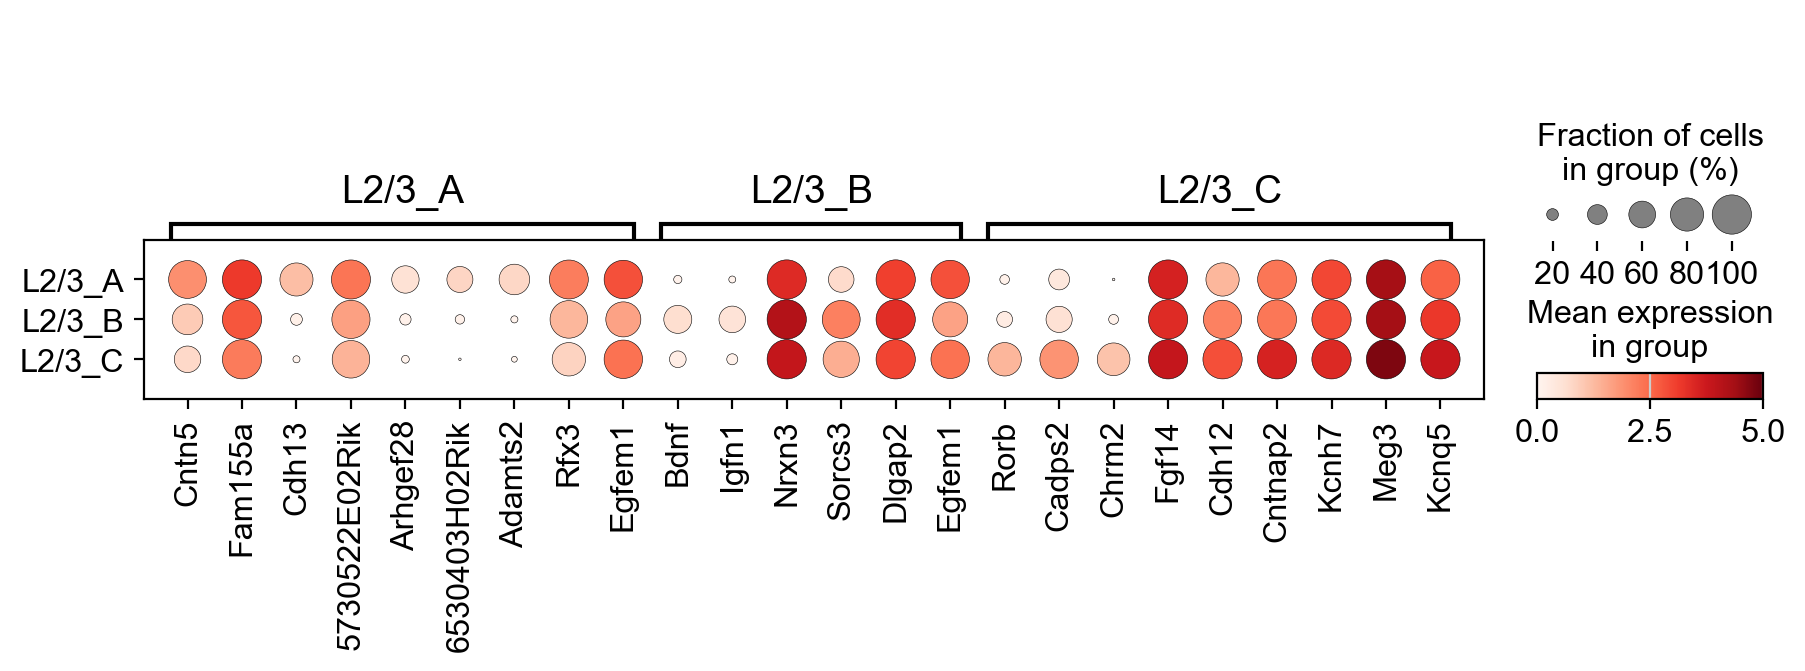

In [44]:
sc.pl.dotplot(
    adata_l23, markers, 
    groupby="Type", 
    categories_order=["L2/3_A", "L2/3_B", "L2/3_C"], 
    var_group_rotation=0, 
    swap_axes=False, 
    vmin=0, vmax=5, 
                    )

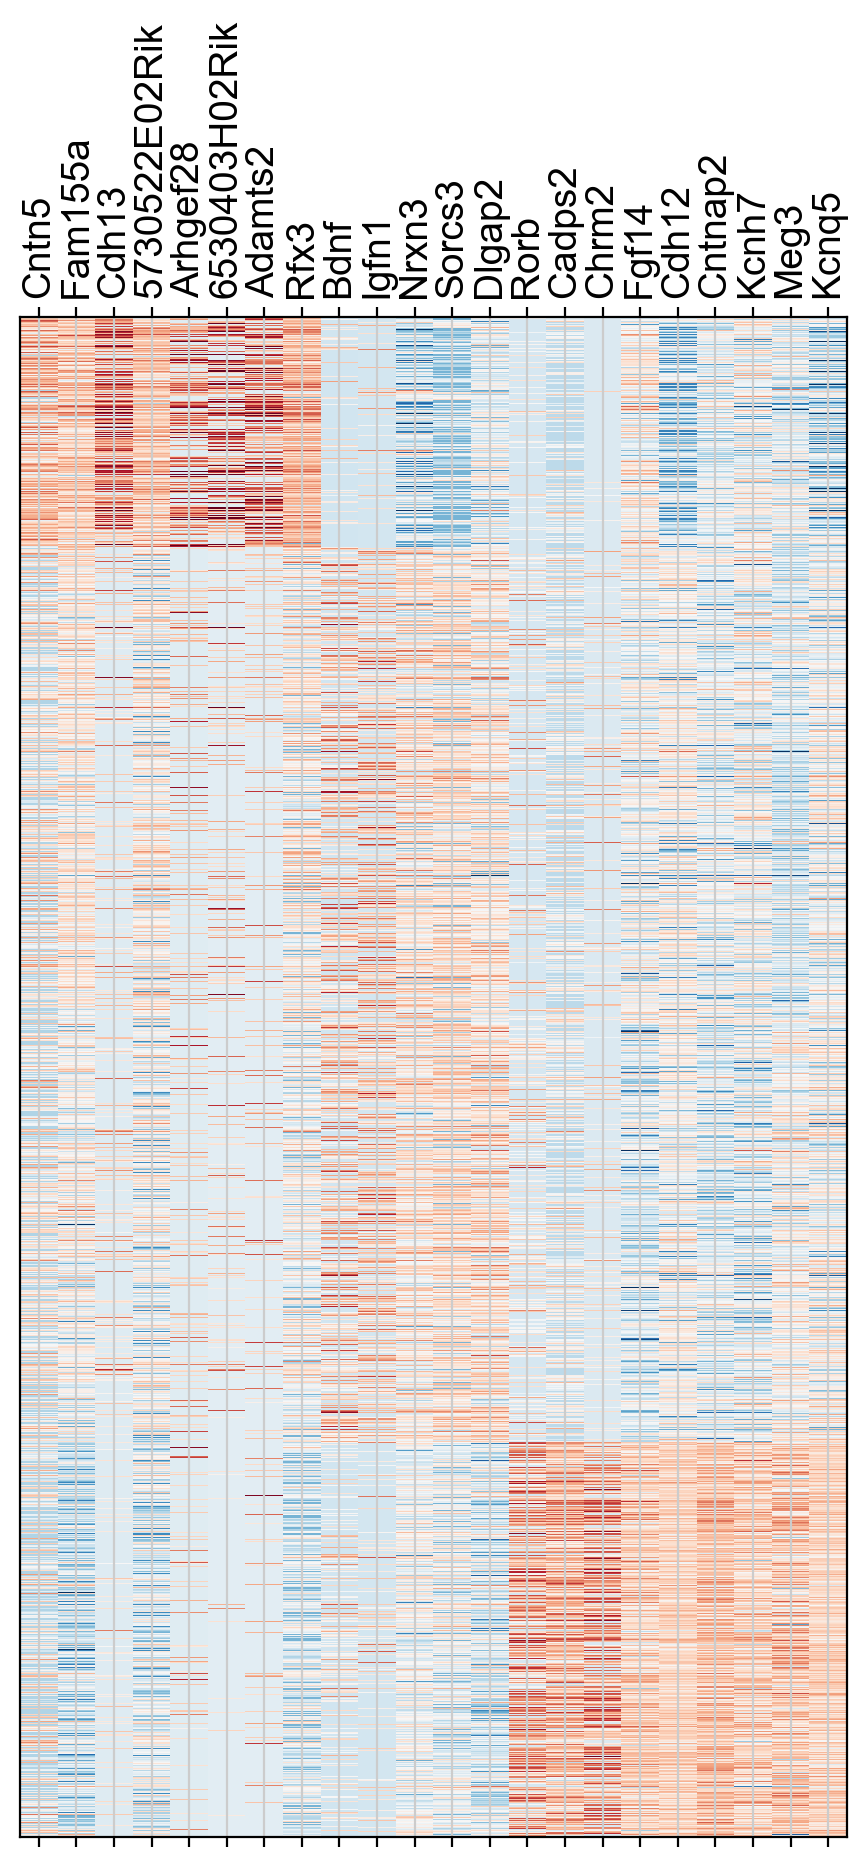

In [143]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

all_markers = []
[all_markers.extend(markers) for markers in results["binary_genes"]]
all_markers = [marker for marker in all_markers if marker != "Egfem1"]

df_X = pd.DataFrame(adata_l23.raw[:, all_markers].X.toarray(), index=adata_l23.obs_names, columns=all_markers) #cell-by-gene
clusters = adata_l23.obs["Type"]
df_X_clusters = pd.concat([df_X, clusters], axis=1)

matrix = np.array(df_X_clusters.sort_values(by=["Type"], key=lambda col: col.str.lower()).drop(["Type"], axis=1))

fig, ax = plt.subplots()
ax.matshow(zscore(matrix, axis=0), cmap="RdBu_r", aspect=0.01, vmin=-4, vmax=4) # 
ax.set_xticks(np.arange(0, 22, 1))
ax.set_xticklabels(all_markers, rotation=90)
ax.set_yticks(())
fig.set_size_inches(6, 10)
plt.show(block=False)

In [120]:
adata_l23.raw[:, all_markers].X.toarray()

array([[0.46671227, 2.3528864 , 0.        , ..., 3.6802993 , 4.955503  ,
        3.7385557 ],
       [0.50622827, 1.4574771 , 0.        , ..., 2.4461963 , 4.383059  ,
        3.5249212 ],
       [0.        , 2.824872  , 0.        , ..., 3.508768  , 4.938724  ,
        3.625518  ],
       ...,
       [1.791343  , 3.1716049 , 0.        , ..., 3.0094416 , 4.3302402 ,
        3.7130845 ],
       [2.0572336 , 2.5985553 , 0.3374925 , ..., 3.4244502 , 4.417533  ,
        3.2222998 ],
       [1.5138087 , 2.7946777 , 0.        , ..., 2.7197165 , 3.991944  ,
        3.4567807 ]], dtype=float32)

In [110]:
np.min(matrix)

-9.46254

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


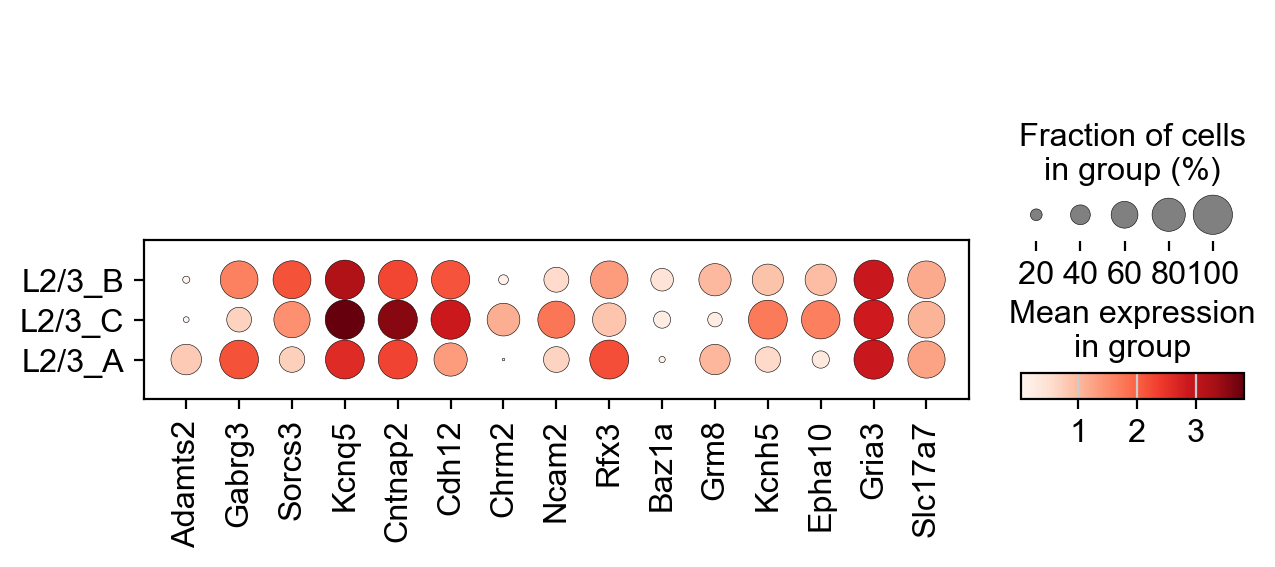

In [40]:
new_markers = ["Adamts2", "Gabrg3", "Sorcs3", "Kcnq5", "Cntnap2", "Cdh12", "Chrm2", "Ncam2", "Rfx3", "Baz1a", "Grm8", "Kcnh5", "Epha10", "Gria3", "Slc17a7"]
sc.pl.dotplot(adata_l23, new_markers, groupby="Type", swap_axes=False)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


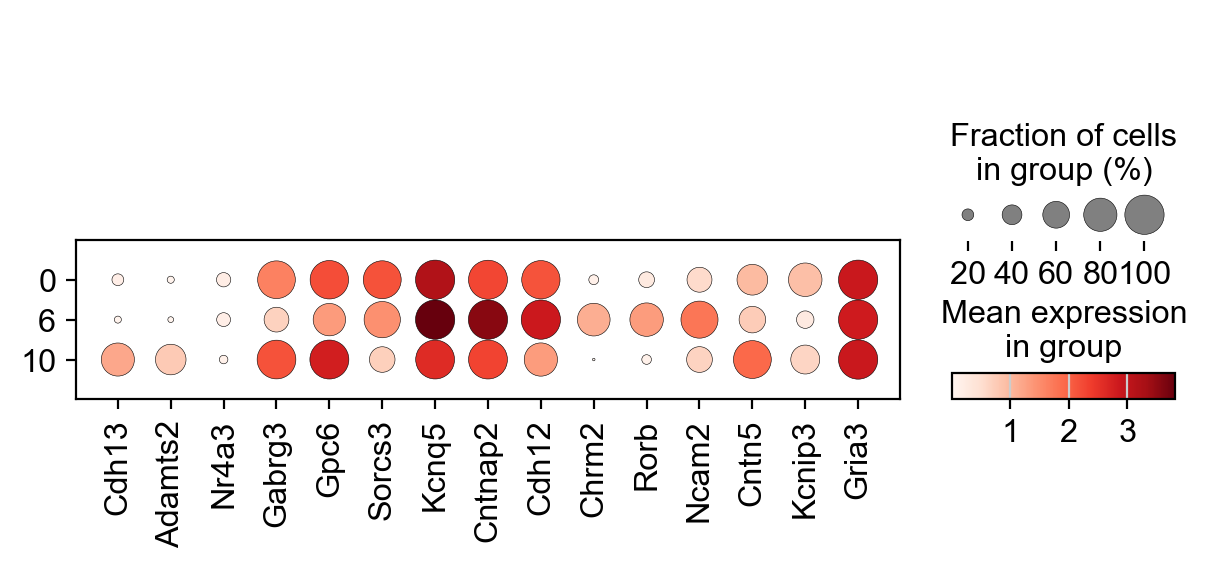

In [8]:
orig_markers = ["Cdh13", "Adamts2", "Nr4a3", "Gabrg3", "Gpc6", "Sorcs3", "Kcnq5", "Cntnap2", "Cdh12", "Chrm2", "Rorb", "Ncam2", "Cntn5", "Kcnip3", "Gria3"]

sc.pl.dotplot(adata_l23, orig_markers, groupby="leiden", swap_axes=False)

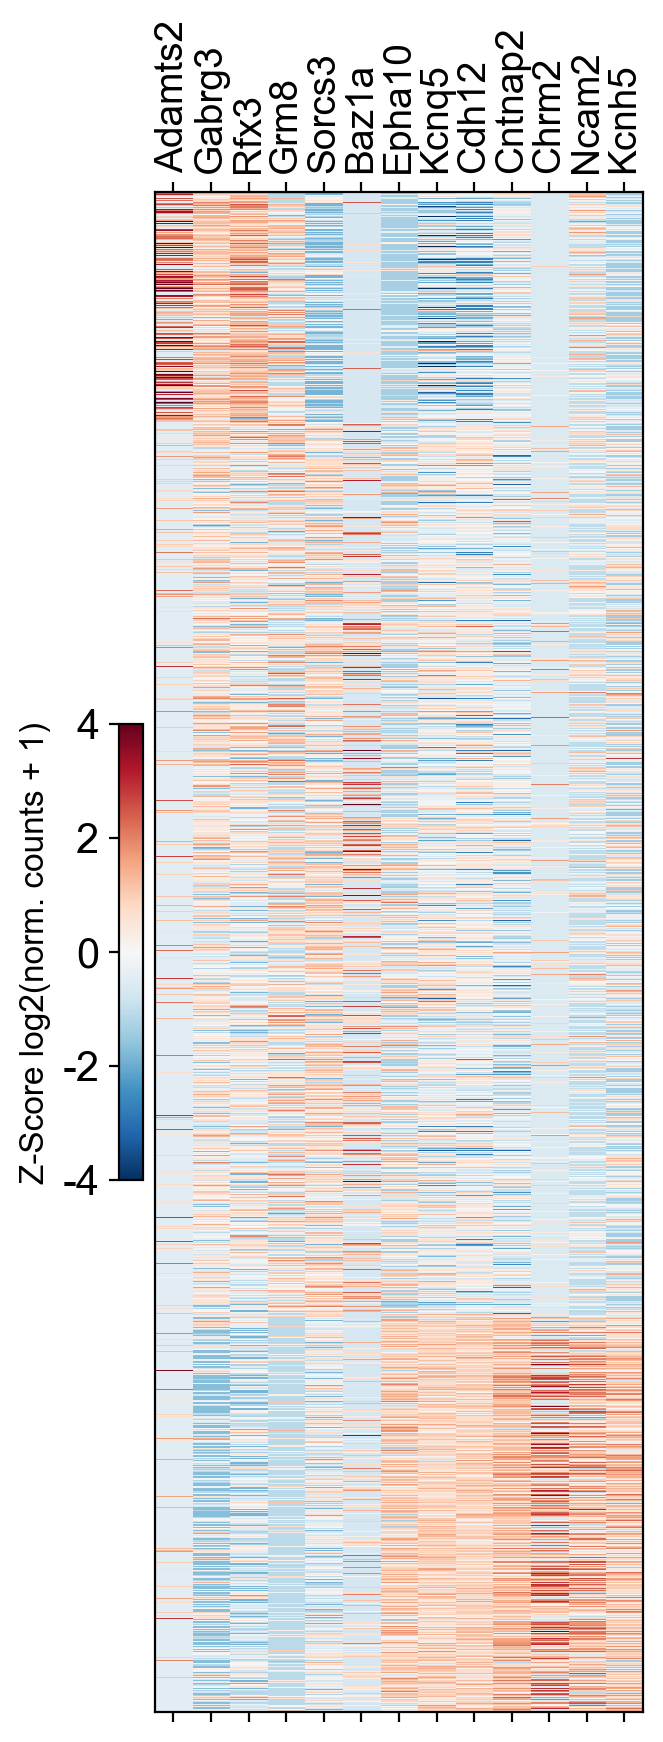

In [155]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter

new_markers = ["Adamts2", "Gabrg3", "Rfx3", 
               "Grm8", "Sorcs3", "Baz1a", "Epha10", "Kcnq5", 
               "Cdh12", "Cntnap2", "Chrm2", "Ncam2", "Kcnh5"]

# , "Gria3", "Slc17a7"

df_X = pd.DataFrame(adata_l23.raw[:, new_markers].X.toarray(), index=adata_l23.obs_names, columns=new_markers) #cell-by-gene
clusters = adata_l23.obs["Type"]
df_X_clusters = pd.concat([df_X, clusters], axis=1)

matrix = np.array(df_X_clusters.sort_values(by=["Type"], key=lambda col: col.str.lower()).drop(["Type"], axis=1))

fig, ax = plt.subplots()
ax.matshow(zscore(matrix, axis=0), cmap="RdBu_r", aspect=0.01, vmin=-4, vmax=4)
ax.set_xticks(np.arange(0, 13, 1))
ax.set_xticklabels(new_markers, rotation=90)
ax.set_yticks(())
ax.grid(False)
cax = inset_axes(ax, width='5%', height='30%', loc='center left', borderpad=-1)
colorbar = fig.colorbar(ax.images[0], cax=cax)
colorbar.set_label('Z-Score log2(norm. counts + 1)', color='k', fontsize=12)
cax.yaxis.tick_left()
cax.yaxis.set_label_position('left')
cax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
cax.grid(False)
cax.tick_params(labelsize=15)
fig.set_size_inches(6, 10)
plt.show(block=False)